In [175]:
from rdkit import Chem
from rdkit.Chem import rdChemReactions
from rdkit.Chem import AllChem
import re
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
%matplotlib inline

In [7]:
# read in data

r_file = '../data/intra_gsm/intra_rxns_reactants.sdf'
p_file = '../data/intra_gsm/intra_rxns_products.sdf'

data = [Chem.SDMolSupplier(r_file, removeHs=False, sanitize=False),
        Chem.SDMolSupplier(p_file, removeHs=False, sanitize=False)]
data = [(x, y) for (x, y) in zip(data[0], data[1]) if (x, y)]

In [8]:
# number of bond changes (does NOT include bond order changes)

def get_num_bond_changes(r, p):
    
    r_bonds = []
    for b in r.GetBonds():
        r_bonds.append(tuple(sorted((b.GetBeginAtomIdx(), b.GetEndAtomIdx()))))

    p_bonds = []
    for b in p.GetBonds():
        p_bonds.append(tuple(sorted((b.GetBeginAtomIdx(), b.GetEndAtomIdx()))))
        
    all_changes = len(set(r_bonds+p_bonds))
    return (all_changes-len(r_bonds)) + (all_changes-len(p_bonds))

bond_changes = [get_num_bond_changes(mols[0], mols[1]) for mols in data]

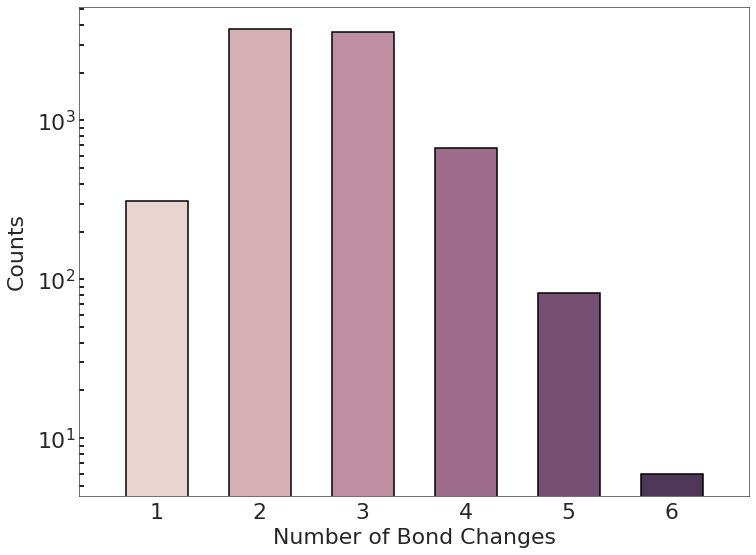

In [324]:
with sns.axes_style('white', rc={'axes.edgecolor': '.3', 'ytick.left': True}):
    fig, ax = plt.subplots(figsize=(12,9))

box_width = 0.6
palette = sns.cubehelix_palette(len(set(bond_changes)), dark=0.25)
width_bak = sns.categorical._BarPlotter.width
sns.categorical._BarPlotter.width = box_width
sns.categorical._BarPlotter.width = width_bak

ax = sns.countplot(x=bond_changes, ax=ax, linewidth=1.5, edgecolor='k', palette=palette)

ax.set_yscale('log')
ax.tick_params(which='both', direction='out', labelsize=22)
ax.set_xlabel('Number of Bond Changes', fontsize=22, labelpad=5)
ax.set_ylabel('Counts', fontsize=22, labelpad=10)
ax.yaxis.set_tick_params(which='both', width=2, direction='in', length=5)
ax.set_xlim(-0.75,len(set(bond_changes))-0.25);

In [131]:
# number of bond change types

def get_changes_bond_type(r, p):

    r_bonds = []
    for b in r.GetBonds():
        r_bonds.append(tuple(sorted((b.GetBeginAtomIdx(), b.GetEndAtomIdx()))))

    p_bonds = []
    for b in p.GetBonds():
        p_bonds.append(tuple(sorted((b.GetBeginAtomIdx(), b.GetEndAtomIdx()))))

    all_changes = set(r_bonds+p_bonds)

    change_indices = []
    change_indices.extend([x for x in r_bonds if x not in p_bonds])
    change_indices.extend([x for x in p_bonds if x not in r_bonds])
    
    return [tuple(sorted((r.GetAtomWithIdx(i).GetSymbol(), r.GetAtomWithIdx(j).GetSymbol()))) for i,j in change_indices]

In [132]:
bond_types = [get_changes_bond_type(mols[0], mols[1]) for mols in data]
bond_types = [y for x in bond_types for y in x]
bond_type_counter = {t:0 for t in list(set(bond_types))}
for bt in bond_types:
    bond_type_counter[bt] += 1

In [133]:
bond_type_counter

{('H', 'O'): 1619,
 ('C', 'O'): 2688,
 ('C', 'C'): 6147,
 ('N', 'N'): 174,
 ('C', 'H'): 7465,
 ('O', 'O'): 33,
 ('N', 'O'): 196,
 ('H', 'N'): 1624,
 ('C', 'N'): 1777}

In [134]:
bond_type_counter_plot = {'C-H': 7465,
                          'C-C': 6147,
                          'C-N': 1777,
                          'C-O': 2688,
                          'N-H': 1624,
                          'N-N': 174,
                          'N-O': 196,
                          'O-H': 1619,
                          'O-O': 33}

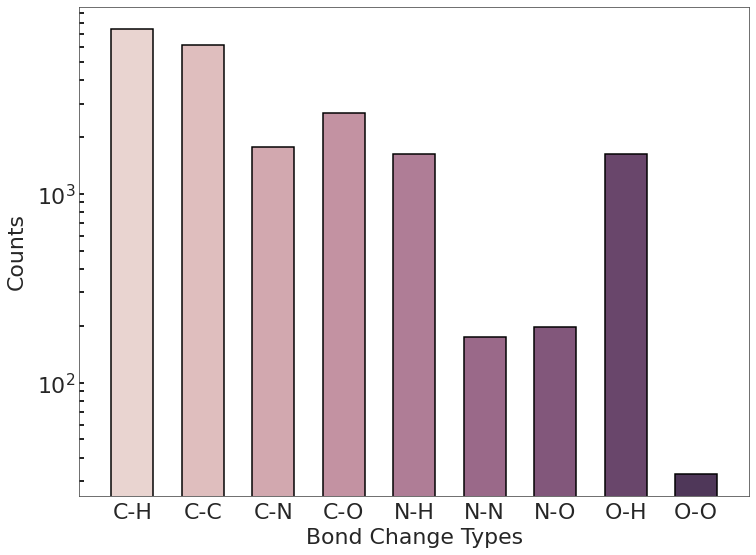

In [325]:
with sns.axes_style('white', rc={'axes.edgecolor': '.3', 'ytick.left': True}):
    fig, ax = plt.subplots(figsize=(12,9))

box_width = 0.6
palette = sns.cubehelix_palette(len(bond_type_df), dark=0.25)
width_bak = sns.categorical._BarPlotter.width
sns.categorical._BarPlotter.width = box_width
sns.categorical._BarPlotter.width = width_bak

ax = sns.barplot(x=list(bond_type_counter_plot.keys()), y=list(bond_type_counter_plot.values()),
                 ax=ax, linewidth=1.5, edgecolor='k', palette=palette)

ax.set_yscale('log')
ax.tick_params(which='both', direction='out', labelsize=22)
ax.set_xlabel('Bond Change Types', fontsize=22, labelpad=5)
ax.set_ylabel('Counts', fontsize=22, labelpad=10)
ax.yaxis.set_tick_params(which='both', width=2, direction='in', length=5)
ax.set_xlim(-0.75,len(bond_type_df)-0.25);

In [232]:
# unique reaction templates
r_smiles = []
with open(r_file) as f:
    mol = []
    for line in f:
        mol.append(line)
        if "$$$$" in line:
            r_smiles.append(mol[0].rstrip())
            mol = []
p_smiles = []
with open(p_file) as f:
    mol = []
    for line in f:
        mol.append(line)
        if "$$$$" in line:
            p_smiles.append(mol[0].rstrip())
            mol = []
rxn_smiles = [r+'>>'+p for r,p in zip(r_smiles, p_smiles)]

In [243]:
def reassign_atom_mapping(transform):
    '''This function takes an atom-mapped reaction SMILES and reassigns
    the atom-mapping labels (numbers) from left to right, once
    that transform has been canonicalized.'''

    all_labels = re.findall('\:([0-9]+)\]', transform)

    # Define list of replacements which matches all_labels *IN ORDER*
    replacements = []
    replacement_dict = {}
    counter = 1
    for label in all_labels: # keep in order! this is important
        if label not in replacement_dict:
            replacement_dict[label] = str(counter)
            counter += 1
        replacements.append(replacement_dict[label])

    # Perform replacements in order
    transform_newmaps = re.sub('\:[0-9]+\]',
        lambda match: (':' + replacements.pop(0) + ']'),
        transform)

    return transform_newmaps

def canonicalize_transform(transform):
    '''This function takes an atom-mapped SMARTS transform and
    converts it to a canonical form by, if nececssary, rearranging
    the order of reactant and product templates and reassigning
    atom maps.'''

    transform_reordered = '>>'.join([canonicalize_template(x) for x in transform.split('>>')])
    return reassign_atom_mapping(transform_reordered)

def canonicalize_template(template):
    '''This function takes one-half of a template SMARTS string
    (i.e., reactants or products) and re-orders them based on
    an equivalent string without atom mapping.'''

    # Strip labels to get sort orders
    template_nolabels = re.sub('\:[0-9]+\]', ']', template)

    # Split into separate molecules *WITHOUT wrapper parentheses*
    template_nolabels_mols = template_nolabels[1:-1].split(').(')
    template_mols          = template[1:-1].split(').(')

    # Split into fragments within those molecules
    for i in range(len(template_mols)):
        nolabel_mol_frags = template_nolabels_mols[i].split('.')
        mol_frags         = template_mols[i].split('.')

        # Get sort order within molecule, defined WITHOUT labels
        sortorder = [j[0] for j in sorted(enumerate(nolabel_mol_frags), key = lambda x:x[1])]

        # Apply sorting and merge list back into overall mol fragment
        template_nolabels_mols[i] = '.'.join([nolabel_mol_frags[j] for j in sortorder])
        template_mols[i]          = '.'.join([mol_frags[j] for j in sortorder])

    # Get sort order between molecules, defined WITHOUT labels
    sortorder = [j[0] for j in sorted(enumerate(template_nolabels_mols), key = lambda x:x[1])]

    # Apply sorting and merge list back into overall transform
    template = '.'.join([template_mols[i] for i in sortorder])

    return template


def clean_branching(template):
    '''fix very specific issue where smiles can be reordered to remove single branch'''
    
    reactant_str = template.split('>>')[0]
    product_str = template.split('>>')[1]
    
    branch = re.findall(r'\(.*?\)', reactant_str)
    if len(branch) == 1:
        frags = reactant_str.split(branch[0])
        branch = branch[0][1:-1]
        reactant_str = frags[1] + frags[0] + branch
        
    branch = re.findall(r'\(.*?\)', product_str)
    if len(branch) == 1:
        frags = product_str.split(branch[0])
        branch = branch[0][1:-1]
        product_str = frags[1] + frags[0] + branch
        
    return reactant_str + '>>' + product_str


def reverse_reaction(rxn):

    reactant_str = rxn.split('>>')[0]
    product_str = rxn.split('>>')[1]

    return product_str + '>>' + reactant_str


def get_simple_template(rxn):

    try:

        rxn_mol = AllChem.ReactionFromSmarts(rxn, useSmiles=True)
        rxn_mol.Initialize()

        reactant_indices = rxn_mol.GetReactingAtoms()
        reactant_indices = [list(x) for x in reactant_indices]

        reverse_rxn_mol = AllChem.ReactionFromSmarts(reverse_reaction(rxn), useSmiles=True)
        reverse_rxn_mol.Initialize()

        product_indices = reverse_rxn_mol.GetReactingAtoms()
        product_indices = [list(x) for x in product_indices]

        products = []
        reactants = []

        for i, reactant in enumerate(rxn_mol.GetReactants()):
            if reactant_indices[i]:
                Chem.rdmolops.RemoveStereochemistry(reactant)
                reactants.append(Chem.rdmolfiles.MolFragmentToSmiles(reactant, reactant_indices[i]))

        for i, product in enumerate(rxn_mol.GetProducts()):
            if product_indices[i]:
                Chem.rdmolops.RemoveStereochemistry(product)
                products.append(Chem.rdmolfiles.MolFragmentToSmiles(product, product_indices[i]))

        transform = "(" + ").(".join(products) + '>>' + ").(".join(reactants) + ")"
        transform = re.sub('[.](?![).(])', ').(', transform)
        if ')>>(' in transform:
            pass
        else:
            transform = re.sub('>>', ')>>(', transform, count=1)
        transform = canonicalize_transform(transform)
        transform = clean_branching(transform)

        return transform

    except Exception as e:
        print(e)
        print(rxn)
        return None

In [265]:
rxn_templates = [get_simple_template(rxn) for rxn in rxn_smiles]
rxn_df = pd.Series(rxn_templates, name='template')
rxn_counts = rxn_df.value_counts()

In [266]:
templates = ['Total Reactions', 'Total Templates', 'Unique Templates']
templates.extend(list(rxn_counts[0:20].index))
counts = [len(rxn_df), len(rxn_counts), sum(rxn_counts == 1)]
counts.extend(list(rxn_counts[0:20].values))

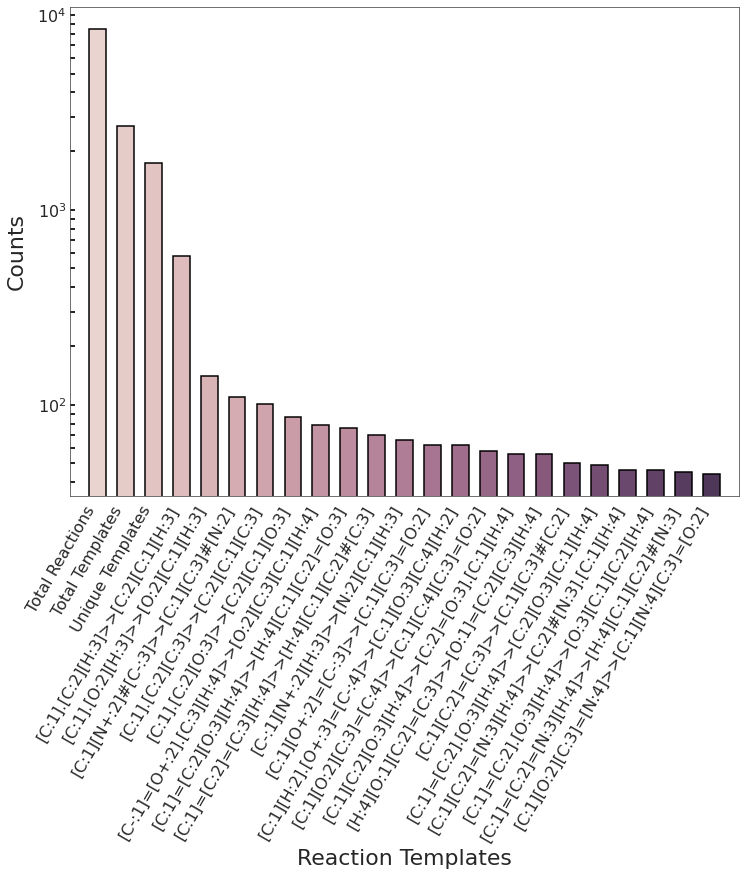

In [343]:
with sns.axes_style('white', rc={'axes.edgecolor': '.3', 'ytick.left': True}):
    fig, ax = plt.subplots(figsize=(12,9))

box_width = 0.6
palette = sns.cubehelix_palette(len(templates), dark=0.25)
width_bak = sns.categorical._BarPlotter.width
sns.categorical._BarPlotter.width = box_width
sns.categorical._BarPlotter.width = width_bak

ax = sns.barplot(x=templates, y=counts, ax=ax, linewidth=1.5, edgecolor='k', palette=palette)

ax.set_yscale('log')
ax.tick_params(which='both', direction='out', labelsize=16)
ax.set_xlabel('Reaction Templates', fontsize=22, labelpad=5)
ax.set_ylabel('Counts', fontsize=22, labelpad=10);
ax.set_xticklabels(ax.get_xticklabels(), rotation=60, horizontalalignment='right');
ax.yaxis.set_tick_params(which='both', width=2, direction='in', length=5)
ax.set_xlim(-1,len(templates));
plt.savefig('../../../../Windows/Papers/ts_prediction_paper/templates.png', dpi=1200, bbox_inches='tight')

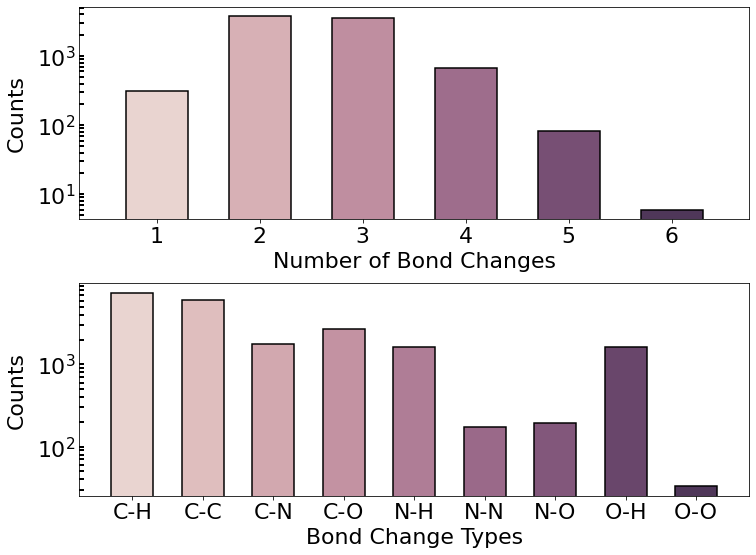

In [344]:
import matplotlib.gridspec as gridspec

with sns.axes_style('white', rc={'axes.edgecolor': '.3', 'ytick.left': True}):
    fig = plt.figure(figsize=(12,9))
gs = gridspec.GridSpec(nrows=2, 
                       ncols=1, 
                       figure=fig, 
                       wspace=0.3,
                       hspace=0.3)
ax2 = fig.add_subplot(gs[0])
ax3 = fig.add_subplot(gs[1])



box_width = 0.6
palette = sns.cubehelix_palette(len(set(bond_changes)), dark=0.25)
sns.countplot(x=bond_changes, ax=ax2, linewidth=1.5, edgecolor='k', palette=palette)

ax2.set_yscale('log')
ax2.tick_params(which='both', direction='out', labelsize=22)
ax2.set_xlabel('Number of Bond Changes', fontsize=22, labelpad=5)
ax2.set_ylabel('Counts', fontsize=22, labelpad=10)
ax2.yaxis.set_tick_params(which='both', width=2, direction='in', length=5)
ax2.set_xlim(-0.75,len(set(bond_changes))-0.25);


palette = sns.cubehelix_palette(len(bond_type_df), dark=0.25)
sns.barplot(x=list(bond_type_counter_plot.keys()), y=list(bond_type_counter_plot.values()),
            ax=ax3, linewidth=1.5, edgecolor='k', palette=palette)

ax3.set_yscale('log')
ax3.tick_params(which='both', direction='out', labelsize=22)
ax3.set_xlabel('Bond Change Types', fontsize=22, labelpad=5)
ax3.set_ylabel('Counts', fontsize=22, labelpad=10)
ax3.yaxis.set_tick_params(which='both', width=2, direction='in', length=5)
ax3.set_xlim(-0.75,len(bond_type_df)-0.25);
plt.savefig('../../../../Windows/Papers/ts_prediction_paper/data_stats.png', dpi=1200, bbox_inches='tight')